# 0. Installing Dependencies

In [1]:
!pip install graphdatascience
!pip install seaborn
!pip install scipy

You should consider upgrading via the 'C:\Users\EMarrow\Desktop\Python Projects\trnsfrNetwork\trnsfrNetwork-env\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\EMarrow\Desktop\Python Projects\trnsfrNetwork\trnsfrNetwork-env\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\EMarrow\Desktop\Python Projects\trnsfrNetwork\trnsfrNetwork-env\Scripts\python.exe -m pip install --upgrade pip' command.


## 0.1. Setting plot styles

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

rc_params = {
    'axes.facecolor': '#13084a',
    'axes.edgecolor': '#ffffff',
    'axes.labelcolor': '#ffffff',
    'axes.grid': True,
    'grid.alpha': 0.4,
    'text.color': '#ffffff',
    'figure.figsize': (16, 9),
    'figure.facecolor': '#13084a',
    'figure.titlesize': 'x-large',
    'xtick.color': '#ffffff',
    'ytick.color': '#ffffff',
    'font.family': 'monospace',
    'font.style': 'normal',
    'axes.titlesize': 'large',
    'axes.titlepad': 10.0,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
}

sns.set_theme(rc=rc_params)

# 1. Introduction

Football/soccer recruiting is a hyper competitive space that requires intricate strategies to inject talent into a team while running a sustainable financial model. As transfer prices, for young talent especially, continue to skyrocket, it is now all the more important to cultivate talent at the source rather than through selling/development clubs. Portuguese clubs such as Porto, Benfica, and Sporting excel in this regard, utilizing a combination of a strong academy and a mastery of the South American market to have some of the highest net transfer spends (income - expenditure). Take Luis Diaz for example. The Columbian winger who broke out at Porto, leading to a \\$50 million move to quadruple contenders Liverpool, was purchased from the Columbian club Junior FC two years prior for \\$8 million.

To aid such a recruitment philosophy, I have employed a network analysis of the transfer market to identify the "suppliers of the selling clubs". transfermarkt.com is a fantastic online resource that with a little webscraping holds an entire archive of transfer histories and relationships. I have defined the "suppliers" as the various clubs who have sold players to the top 50 clubs in terms of net transfer spend over the past 5 years, or in graph terms, are one degree away from the top 50. Each club is represented as a node with "SOLD_TO" relationships containing properties that include the number of players sold between the two clubs, and the income generated from those transfers. With such an approach, I hope to identify the key suppliers in the network .

## 1.1. Loading in Data from local neo4j Instance

In [3]:
from neo4j import GraphDatabase

def get_edges(tx):
    query = """
        MATCH (c:Club)-[r:SOLD_TO]->(c2:Club)
        RETURN c2.name AS buyingClub,
               c.name AS sellingClub,
               r.transfers AS playersSold,
               r.volume AS income
    """
    result = tx.run(query)
    records = []
    for record in result:
        record_dict = {
            'buyingClub': record['buyingClub'],
            'sellingClub': record['sellingClub'],
            'playersSold': record['playersSold'],
            'income': record['income'],
        }
        records.append(record_dict)
    return records
    
    
def top50(tx):
    query = f"""
        MATCH (c:Club)
        WHERE c.top50 = true
        RETURN c.name AS name,
               c.country AS country,
               c.expenditure AS expenditure,
               c.arrivals AS arrivals,
               c.income AS income,
               c.departures AS departures,
               c.balance AS balance
    """
    result = tx.run(query)
    records = []
    for record in result:
        record_dict = {
            'name': record['name'],
            'country': record['country'],
            'expenditure': record['expenditure'],
            'arrivals': record['arrivals'],
            'income': record['income'],
            'departures': record['departures'],
            'balance': record['balance']
        }
        records.append(record_dict)
    return records

def get_results():
    with GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'top50')) as driver:
        with driver.session(database="netspendtop50") as session:
            top50Summary = session.read_transaction(top50)
            rSummary = session.read_transaction(get_edges)
            return (top50Summary, rSummary)

top50Sum, rSum = get_results()

# 2. Top 50 EDA

In [4]:
import pandas as pd

summary = pd.DataFrame(top50Sum)

Text(0, 0.5, '')

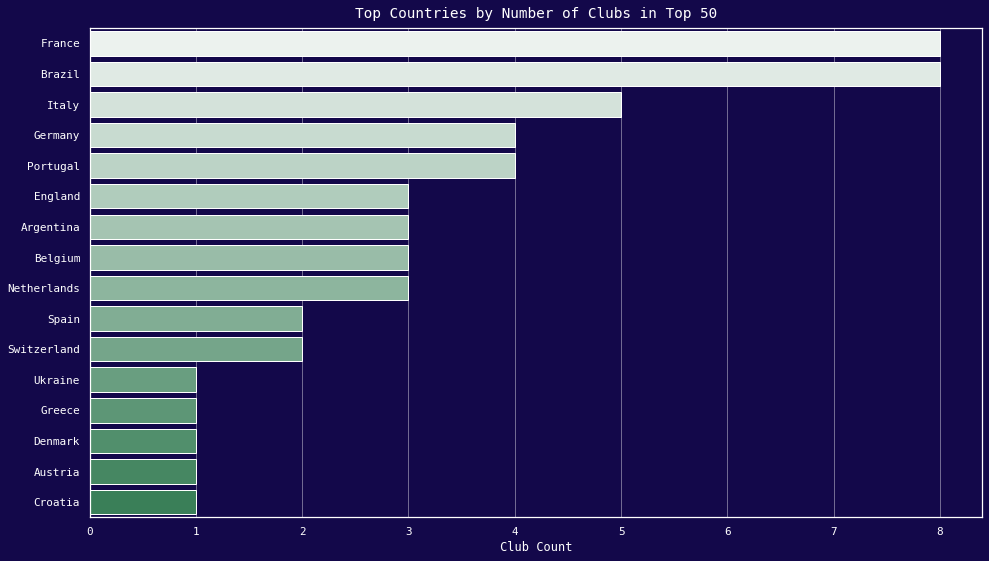

In [5]:
country_count = summary.country.value_counts().reset_index()
n_colors = len(country_count.index.unique())
palette = sns.light_palette('seagreen', n_colors=n_colors)
g = sns.barplot(data=country_count, x='country', y='index', palette=palette, dodge=False)
g.set_title('Top Countries by Number of Clubs in Top 50')
g.set_xlabel('Club Count')
g.set_ylabel('')

In [6]:
import numpy as np

summary['expPerArrival'] = np.around(summary.expenditure.values / summary.arrivals.values, 2)
summary['incPerDeparture'] = np.around(summary.income.values / summary.departures.values, 2)
summary['netPerPlayer'] = summary.incPerDeparture.values - summary.expPerArrival.values

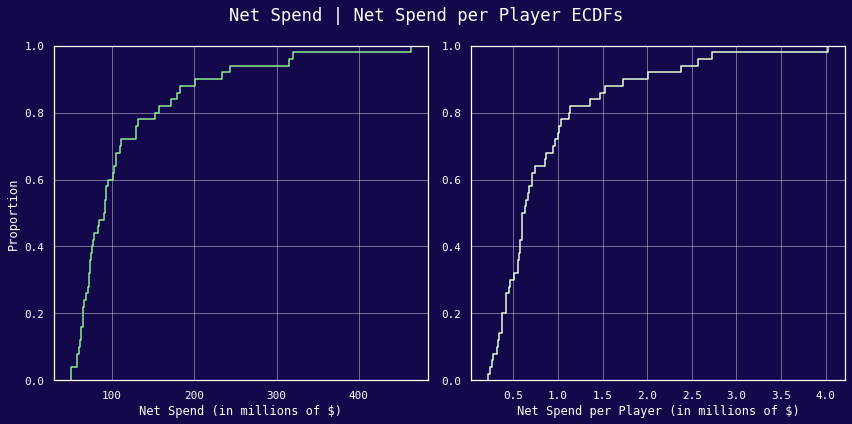

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.ecdfplot(data=summary, x='balance', color='lightgreen', markersize=5, ax=ax[0])
sns.ecdfplot(data=summary, x='netPerPlayer', color='#ECFFDC', markersize=5, ax=ax[1])
ax[0].set_xlabel('Net Spend (in millions of $)')
ax[1].set_xlabel('Net Spend per Player (in millions of $)')
ax[1].set_ylabel('')
fig.suptitle('Net Spend | Net Spend per Player ECDFs')
plt.tight_layout()

Both Net Spend and Net Spend per Player amongst the Top 50 clubs appear to follow a Pareto looking distribution in which the vast majority of the value range is consolidated within the top 20% according to each metric. The top 20% in this case, would relate to the top 10 teams in each category.

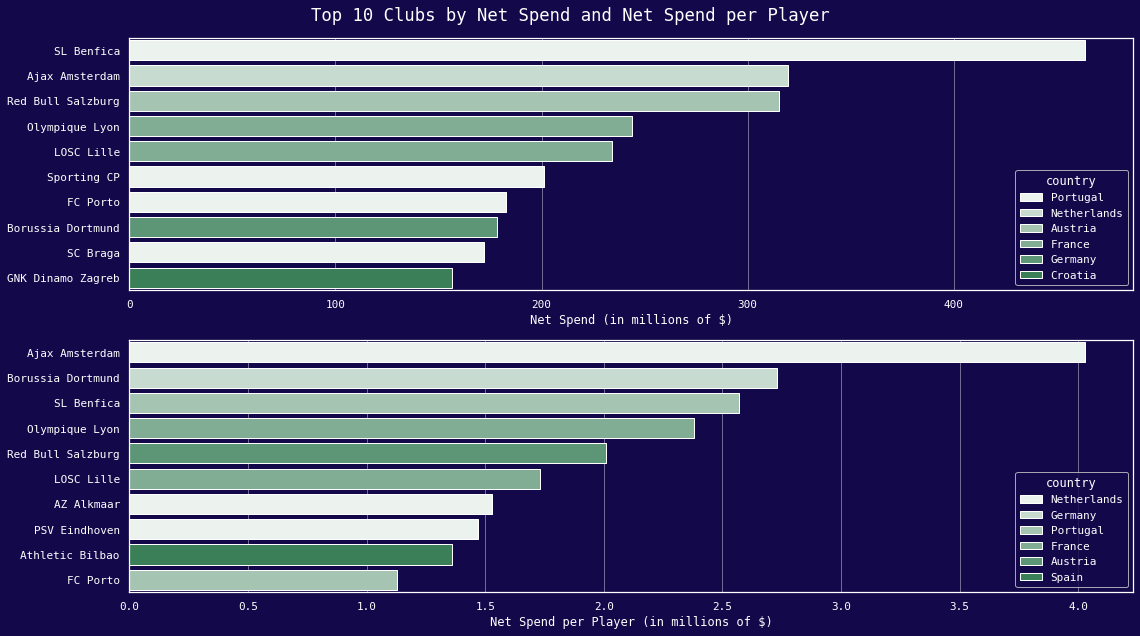

In [8]:
top10_netspend = summary.sort_values('balance', ascending=False).head(10)
top10_netper = summary.sort_values('netPerPlayer', ascending=False).head(10)
fig, ax = plt.subplots(2,1)
sns.barplot(data=top10_netspend, x='balance', y='name', hue='country', dodge=False, palette=sns.light_palette('seagreen'), ax=ax[0])
sns.barplot(data=top10_netper, x='netPerPlayer', y='name', hue='country', dodge=False, palette=sns.light_palette('seagreen'), ax=ax[1])
ax[0].set_ylabel('')
ax[0].set_xlabel('Net Spend (in millions of $)')
ax[1].set_ylabel('')
ax[1].set_xlabel('Net Spend per Player (in millions of $)')
fig.suptitle('Top 10 Clubs by Net Spend and Net Spend per Player')
plt.tight_layout()

Out of top 10 clubs according to Net Spend, four of them are Portuguese and SL Benfica has a considerable advantage over the rest of the field.

However, when Net Spend is normalized, both Sporting CP and SC Braga drop out while a Dutch contingent of Ajax, Az Alkmaar, and PSV Eindhoven possess the country majority with 3 in the top 10.

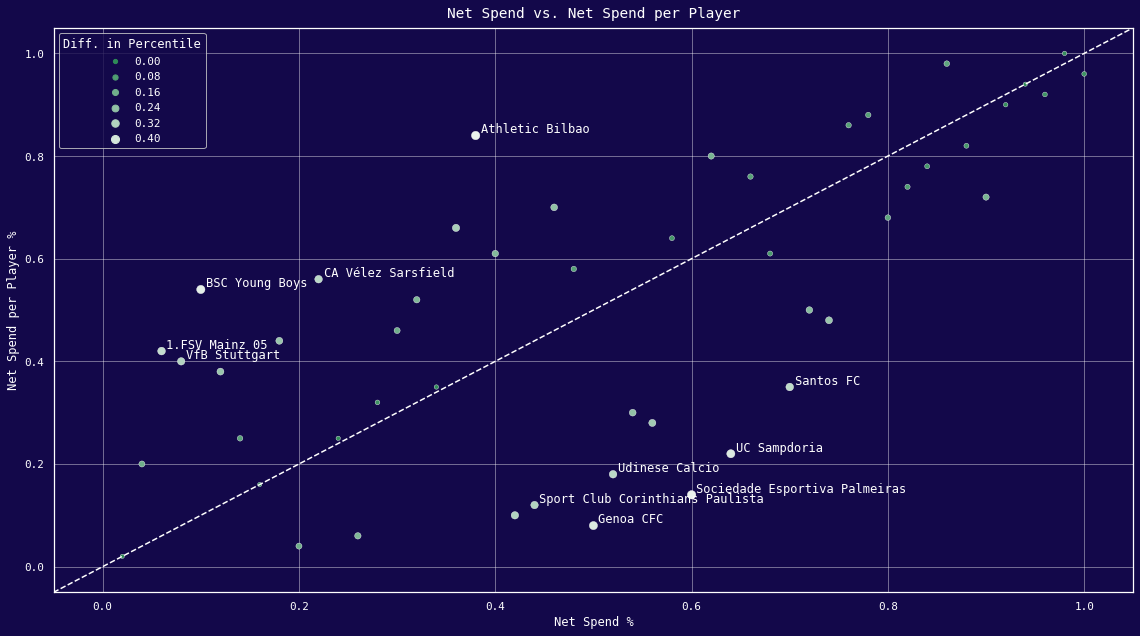

In [9]:
summary['balanceRank'] = summary['balance'].rank(pct=True)
summary['netPerPlayerRank'] = summary['netPerPlayer'].rank(pct=True)
summary['rankMean'] = np.around((summary.balanceRank.values + summary.netPerPlayerRank.values) / 2, 2)
summary['netSpendRankDiff'] = np.abs(summary.balanceRank.values - summary.netPerPlayerRank.values)

palette = sns.light_palette('seagreen', as_cmap=True, reverse=True)
g = sns.scatterplot(data=summary, x='balanceRank', y='netPerPlayerRank', size='netSpendRankDiff', hue='netSpendRankDiff', palette=palette)
g.set_title('Net Spend vs. Net Spend per Player')
g.get_legend().set_title('Diff. in Percentile')
g.set_xlabel('Net Spend %')
g.set_ylabel('Net Spend per Player %')
points_to_label = summary[['name', 'balanceRank', 'netPerPlayerRank', 'netSpendRankDiff']].query('netSpendRankDiff >= 0.32')
for index, row in points_to_label.iterrows():
    g.text(row['balanceRank']+0.005, row['netPerPlayerRank']+0.005, row['name'])
plt.axline((0,0), (1,1), linestyle='--', color='w')
plt.tight_layout()

If we rank the teams using a percentile method based on Net Spend and Net Spend per Player, it becomes clear that many clubs possess a large difference in percentile between the two ranks, as the top 10 bar plots shown earlier suggested.

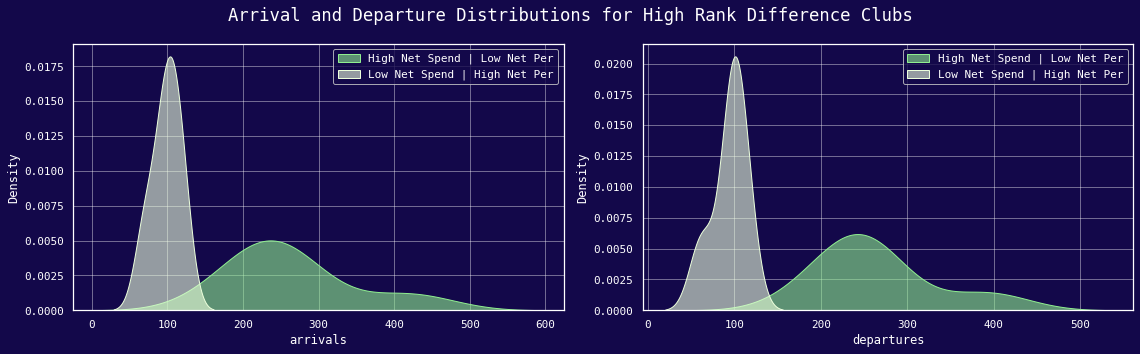

In [10]:
cols = ['arrivals', 'departures']
high_bal = summary[summary.balanceRank - summary.netPerPlayerRank >= 0.32][cols]
low_bal = summary[summary.balanceRank - summary.netPerPlayerRank <= -0.32][cols]
fig, ax = plt.subplots(1,2,figsize=(16,5))
ax_array = [ax[i] for i in range(2)]
axes_cols = zip(cols, ax_array)
for col, axes in axes_cols:
    sns.kdeplot(data=high_bal, x=col, color='lightgreen', fill=True, alpha=0.6, ax=axes)
    sns.kdeplot(data=low_bal, x=col, color='#ECFFDC', fill=True, alpha=0.6, ax=axes)
    axes.legend(['High Net Spend | Low Net Per', 'Low Net Spend | High Net Per'])
fig.suptitle('Arrival and Departure Distributions for High Rank Difference Clubs')
plt.tight_layout()

Clubs that have a high net spend rank but low net per can be classified as clubs that have a greater arrival and departure volume which has enabled them to accrue a high net spend over time. On the other end of the spectrum, clubs with a low net spend and high net per can attribute their balance being in the top 50 to a smaller number of player sales at a higher price.

# 3. Supplier EDA

With the analysis goal to identify clubs that are key actors in the network of clubs that the Top 50 buy from, there are a few key indicators that we aim to maximize/minimize:
- The number of players the club has sold: **MAXIMIZE** as we want to identify active stakeholders in the network
- The income generate from those sales: **MINIMIZE** as we want to find talent at a discounted price
- The number of top 50 clubs that have bought from that club: **MAXIMIZE** as that club supplies a variety of top 50 clubs
- The number of top 50 club countries have bought from that club: **MAXIMIZE** as that club is an active supplier in multiple countries
- The mean ranking of top 50 clubs that have bought from that club: **MAXIMIZE** as this suggests higher probability of profit

In [11]:
edges_i = pd.DataFrame(rSum)

In [12]:
# buyer rank
buyer_country = summary[['name', 'country', 'rankMean']]
edges = edges_i.merge(buyer_country, left_on='buyingClub', right_on='name') \
               .rename(columns={'country': 'buyerCountry', 'rankMean': 'buyerRank'}) \
               .drop(columns='name')

In [13]:
# aggregating by supplier
edges_agg = edges[edges.income != 0].groupby('sellingClub')[['playersSold', 'income', 'buyingClub', 'buyerCountry', 'buyerRank']] \
                                    .agg({'playersSold': 'sum',
                                         'income': 'sum',
                                         'buyingClub': 'count',
                                         'buyerCountry': 'nunique',
                                         'buyerRank': 'mean'})
edges_agg['incomePerPlayer'] = np.around(edges_agg.income.values / edges_agg.playersSold.values, 2)
edges_agg['buyerRank'] = np.around(edges_agg.buyerRank.values, 2)

Text(0.5, 0, 'Players Sold')

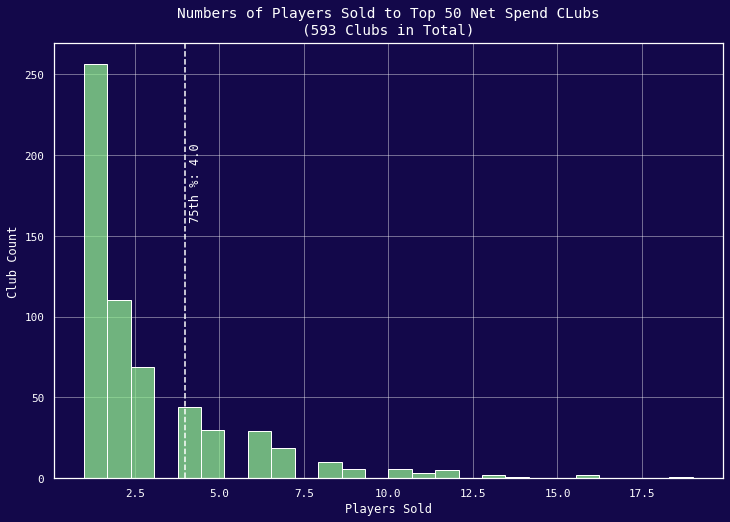

In [14]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=edges_agg, x='playersSold', color='lightgreen', ax=ax)
ax.set_title(f"Numbers of Players Sold to Top 50 Net Spend CLubs\n({edges_agg.shape[0]} Clubs in Total)")
ax.set_ylabel('Club Count')
xntile = np.percentile(edges_agg.playersSold.values, [75])[0]
ax.axvline(x=xntile, linestyle='--', color='w')
plt.text(xntile+0.1,160, f'75th %: {xntile}',rotation=90)
ax.set_xlabel('Players Sold')

The vast majority of supplier nodes in the network have only sold one player. Since this analysis is interested in clubs that have sold a high number of players, clubs that have a players sold value under the 75th percentile of four will be filtered out from here on.

In [15]:
# filtering out clubs with players sold under 4
edges_agg_filt = edges_agg[edges_agg.playersSold >= 4]

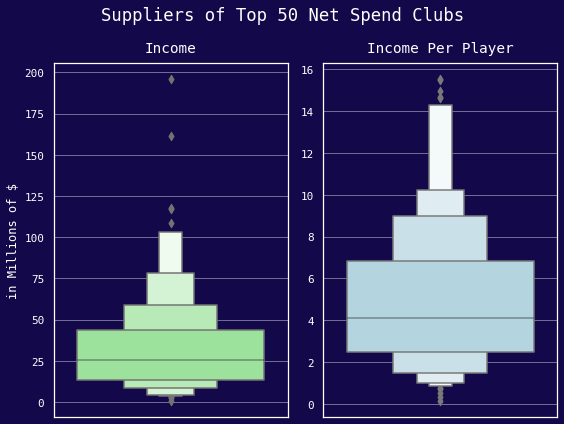

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8,6))
palette = sns.light_palette('seagreen', n_colors=6)
sns.boxenplot(data=edges_agg_filt, y='income', ax=ax[0], color='lightgreen')
ax[0].set_title('Income')
ax[0].set_ylabel('in Millions of $')
sns.boxenplot(data=edges_agg_filt, y='incomePerPlayer', color='lightblue', ax=ax[1])
ax[1].set_title('Income Per Player')
ax[1].set_ylabel('')
fig.suptitle('Suppliers of Top 50 Net Spend Clubs')
plt.tight_layout()

Although the distribution of the income is fairly imbalanced, when it is normalized on a per player basis, the distribution becomes more even as the outliers cover far less of the upper range of values.

In [17]:
diversityagg = edges_agg_filt.reset_index().groupby('playersSold')[['buyingClub', 'buyerCountry']] \
                             .agg(['count', 'min', 'max', 'median']) \
                             .rename(columns={'buyingClub': 'clubs', 'buyerCountry': 'countries'})
diversityagg

clubs                countries               
            count min max median     count min max median
playersSold                                              
4              44   1   4    3.0        44   1   4    2.5
5              30   1   5    4.0        30   1   4    3.0
6              29   3   6    5.0        29   1   5    4.0
7              19   1   7    5.0        19   1   5    3.0
8              10   4   8    6.5        10   4   7    4.5
9               6   3   7    6.5         6   1   5    3.0
10              6   4   8    6.0         6   2   6    3.5
11              3   8   9    8.0         3   4   6    4.0
12              5   2   8    6.0         5   2   5    3.0
13              2   7   8    7.5         2   4   6    5.0
14              1   7   7    7.0         1   3   3    3.0
16              2   7   8    7.5         2   3   5    4.0
19              1   8   8    8.0         1   3   3    3.0

Most of the variation that exists for the countries and clubs suppliers have sold is explained in the range of 4 to 10 players sold. Countries in particular appears to stop having a proportional relationship with clubs and players sold at approximately a count of 6, while clubs diverges from players sold around a count of 8.

To represent these fields in the supplier index, it may be smart to bin together suppliers by player sold counts to determine how impressive it is that they have a certain country or club count given the bin. A inter bin dense rank will be utilized to do so. Both the KDE below and the table above help serve as a guide on how they can be divided in the following manner:
- 4, 5, 6, 7 due to their frequent occurence can all serve as their own respective bins
- 8, 9, 10 due to their similar club and country count ranges
- 11, 12, 13, 14, 16, 19 due to their collective low frequency and lying within a similar range of club and country counts

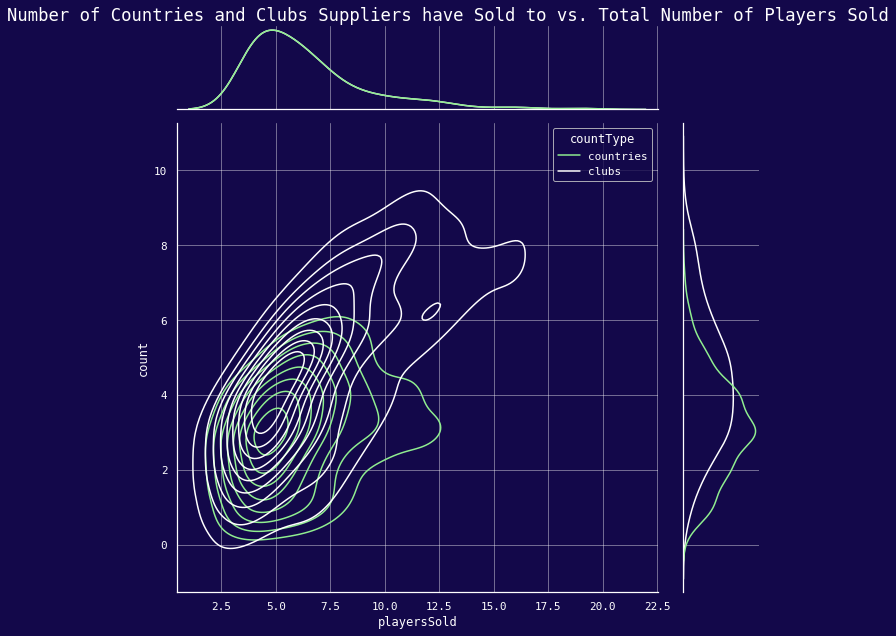

In [18]:
edges_agg_filt_c = edges_agg_filt.copy()
edges_agg_filt_c = edges_agg_filt_c.rename(columns={'buyingClub': 'clubs', 'buyerCountry': 'countries'})
edges_melt = pd.melt(edges_agg_filt_c, id_vars=['playersSold'], value_vars=['clubs', 'countries'],
                     var_name='countType', value_name='count').sort_values('playersSold', ascending=False)
g = sns.jointplot(data=edges_melt, x='playersSold', y='count', hue='countType', palette=['lightgreen', 'white'],
                  kind='kde', height=9)
g.fig.suptitle("Number of Countries and Clubs Suppliers have Sold to vs. Total Number of Players Sold")
g.ax_joint.collections[0].set_alpha(0)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.95)

In [19]:
# dense rank of inter bin count of each respective supplier's distinct country and club counts
from scipy.stats import rankdata

bins = {
    4: [4],
    5: [5],
    6: [6],
    7: [7],
    8: [8,9,10],
    9: [8,9,10],
    10: [8,9,10], 
}

def dense_rank(sold):
    try:
        df = edges_agg_filt[edges_agg_filt.playersSold == sold]
        ranks = df.copy()
    except KeyError:
        df = edges_agg_filt[edges_agg_filt.playersSold > 10]
        ranks = df.copy()
    ranks['clubVarRank'] = rankdata(df.buyingClub.values * -1, method='dense')
    ranks['countryVarRank'] = rankdata(df.buyerCountry.values * -1, method='dense')
    return ranks[['clubVarRank', 'countryVarRank']]

sold_values = edges_agg_filt.playersSold.unique()
rank_dfs = [dense_rank(value) for value in sold_values]
rank_df = pd.concat(rank_dfs)
edges_agg_filt = edges_agg_filt.merge(rank_df, on='sellingClub')

Now that the table fields are prepared, a supplier index can be calculated to help sort the data further to focus the analysis further. The ideal equation values a high volume of players sold, a low profit from those players, a high mean buyer rank according to the mean of the net spend and net spend per player percentiles, and a variety of different buyer clubs and countries.

In [20]:
# suppliers index calculation
def scale_inc(col):
    return ((col - col.mean() / col.std()) / 12) + 1.25

edges_agg_filt['supplierIndex'] = np.around(edges_agg_filt.playersSold / scale_inc(edges_agg_filt.income) \
                                        / ((edges_agg_filt.clubVarRank + edges_agg_filt.countryVarRank) / 2) \
                                        * edges_agg_filt.buyerRank, 4)
edges_agg_filt['top50'] = edges_agg_filt.index.isin(summary.name.unique())

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex,top50
sellingClub,,,,,,,,,,
Cruzeiro Esporte Clube,19,36.69,8,3,0.43,1.93,1,1,1.9387,False
NK Lokomotiva Zagreb,12,14.30,2,2,0.86,1.19,3,3,1.4649,False
Atlético Nacional,12,50.56,8,5,0.59,4.21,1,1,1.3185,False
Hamburger SV,5,19.42,5,4,0.70,3.88,1,1,1.2613,False
Newcastle United,4,12.00,4,4,0.60,3.00,1,1,1.1129,False
Sunderland AFC,5,18.06,5,4,0.56,3.61,1,1,1.0520,False
Torino FC,13,52.20,8,6,0.41,4.02,1,1,0.9679,False
Standard Liège,5,26.73,5,4,0.60,5.35,1,1,0.8865,False
Esporte Clube Bahia,11,16.71,8,4,0.40,1.52,2,2,0.8631,False


# 4. Results

For both Europe and South America, I picked out four teams that had high supplier scores and belonged to smaller league markets to investigate further.

The following are screenshots from neo4j Bloom displaying the supply networks of high ranking clubs according to the supplier index. Each supplier is represented as a green node in the visual, while buyer nodes are colored by country. Edges are sized by the number of players the supplier has sold to that specific club.

## 4.1. South America

### 4.1.1. Cruzeiro Esporte Clube

In [38]:
edges_agg_filt[edges_agg_filt.index == 'Cruzeiro Esporte Clube'].drop(columns=['top50'])

,playersSold,supplierIndex
sellingClub,,
Cruzeiro Esporte Clube,19,1.9387


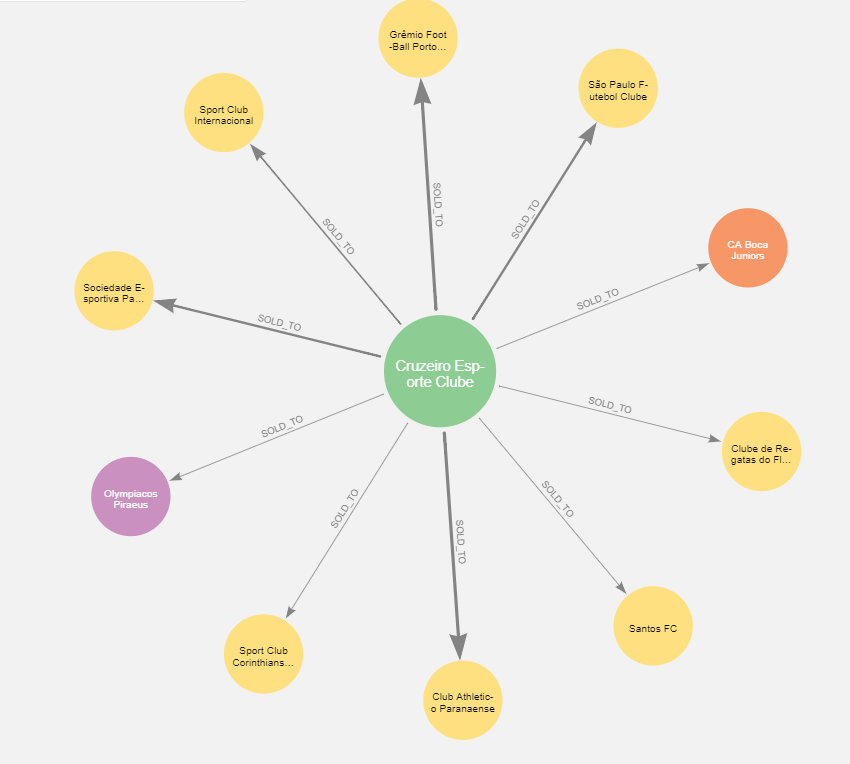

In [23]:
Image(filename='img/cruzeiroesporte.png', width=650)

With 19 players sold to the Top 50 Net Spend clubs in the last 5 years, Cruzeiro Esporte Clube had more outgoings than any other suppliers. Currently in Brazil's second division, their history boasts being the youth club of the likes of Brazilian legends Ronaldo Phenomeno, Rivaldo, and Maicon.

The network shows their significant contribution to Brazilian clubs (nodes colored yellow), especially Palmeiras, Gremio, Sao Paulo and Paranaense. In fact, Cruzeiro have sold at least one player to all 8 teams hailing from Brazil in the Top 50.

### 4.1.2. Atlético Nacional

In [24]:
edges_agg_filt[edges_agg_filt.index == 'Atlético Nacional'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
Atlético Nacional,12,50.56,8,5,0.59,4.21,1,1,1.3185


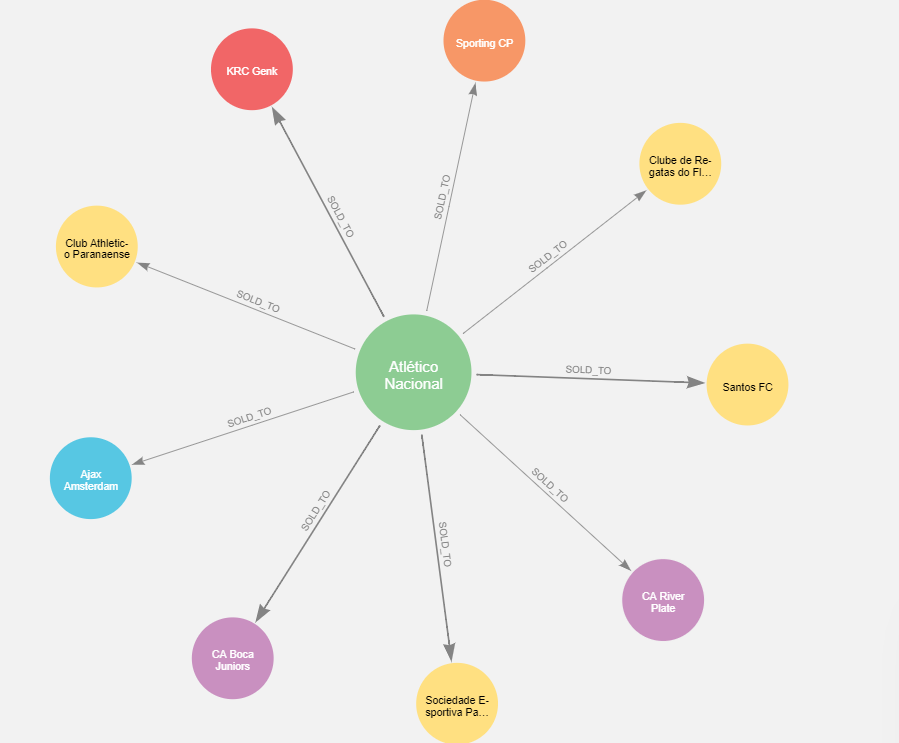

In [25]:
Image(filename='img/atletico.png', width=650)

Athletico Nacional's high supplier index is due to the amount of different countries, in which their buyers reside, that they have sold to including:
- Brazil (yellow)
- Argentina (purple)
- Belgium (red)
- Portugal (orange)
- Ajax Amsterdam (blue)

Standing as one of the traditonal powerhouses in Columbia, it is not surprising to see that the majority of clubs that it has sold to are South American.

### 4.1.3. Esporte Clube Bahia

In [26]:
edges_agg_filt[edges_agg_filt.index == 'Esporte Clube Bahia'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
Esporte Clube Bahia,11,16.71,8,4,0.4,1.52,2,2,0.8631


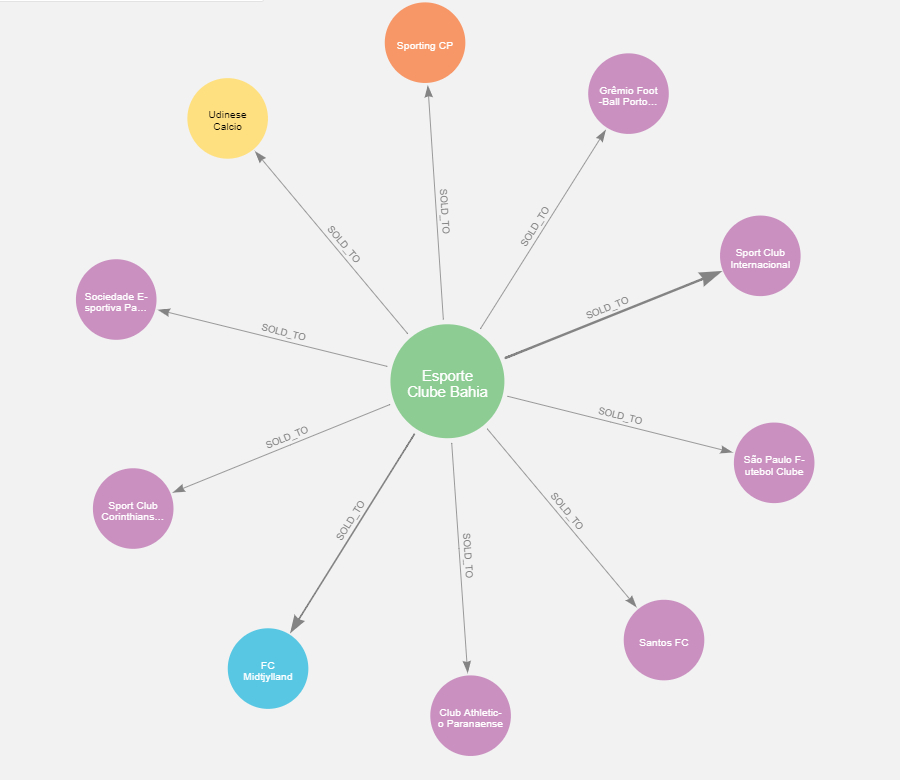

In [27]:
Image(filename='img/bahia.png', width=650)

Like Cruzeiro, Esporte Clube Bahia boasts a similar supply line to Brazilian clubs (nodes colored Purple) and is currently playing in the Brazilian second division, but differs in the fact that it has sold to more European teams including Udinese (Italy), FC Midtjylland (Denmark), and Sporting CP (Portugal).

### 4.1.4. Club Atlético Rosario Central

In [28]:
edges_agg_filt[edges_agg_filt.index == 'CA Rosario Central'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
CA Rosario Central,5,16.62,4,4,0.62,3.32,2,1,0.8131


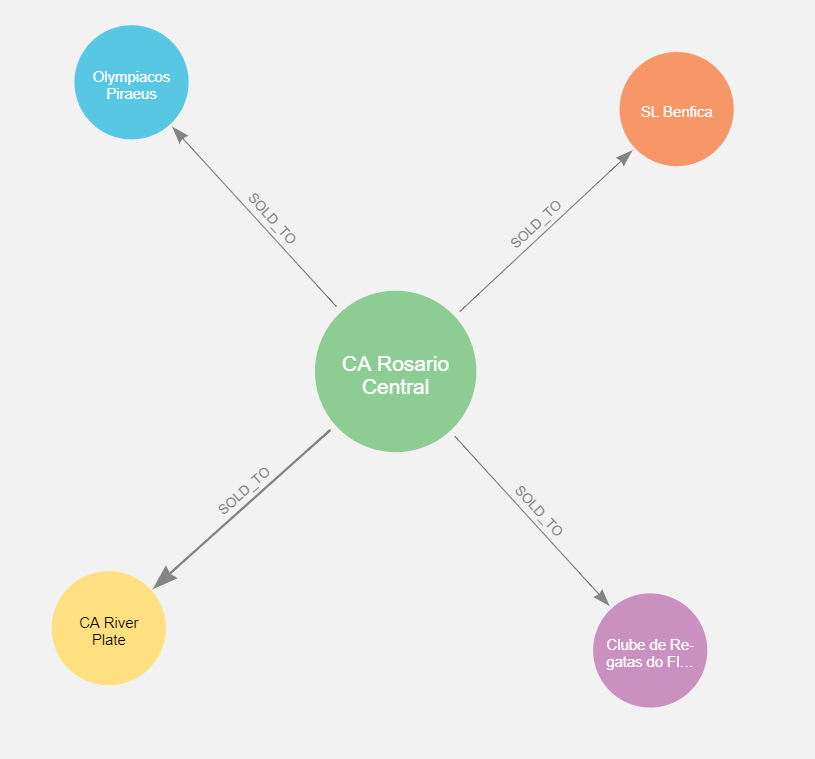

In [29]:
Image(filename='img/rosario.png', width=650)

Although it does not have the supplier volume as the clubs mentioned earlier, the historic Argentinian club Rosario scores highly due to the fact that the buyers of the 5 players they have sold consist of 4 different clubs originating from 4 different countries.



## 4.2. Europe

### 4.2.1. Heracles Almelo

In [30]:
edges_agg_filt[edges_agg_filt.index == 'Heracles Almelo'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
Heracles Almelo,7,17.46,5,5,0.5,2.49,3,1,0.6701


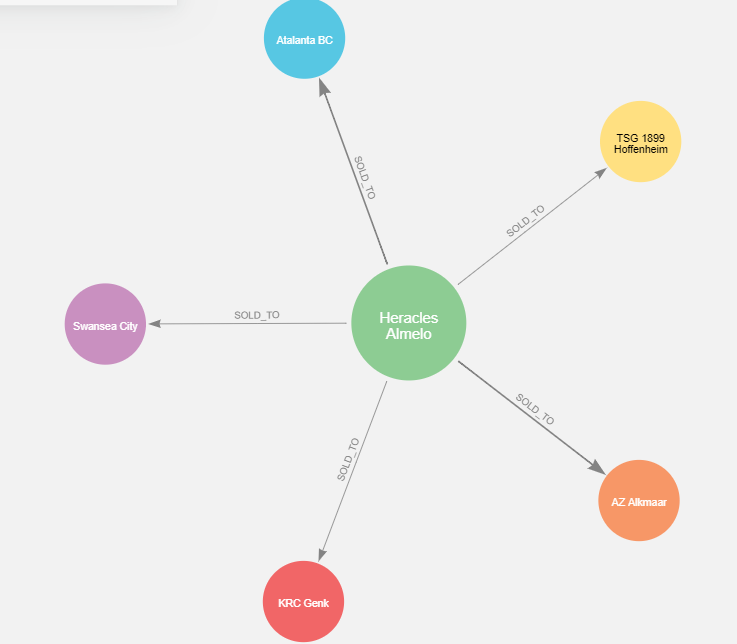

In [31]:
Image(filename='img/heracles.png', width=650)

Netherlands First Division Heracles Almelo shares similar attributes to the above Rosario in the fact that it has a high degree of variation in relation to buyer club and country. Seeing their strong relationship to Atalanta BC in relation to the other clubs they sell to in particular, is promising as the Italian club has made a reputation for itself in recent years for their scouting and talent development.

### 4.2.2. FC Nordsjaelland

In [32]:
edges_agg_filt[edges_agg_filt.index == 'FC Nordsjaelland'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
FC Nordsjaelland,5,35.49,5,4,0.7,7.1,1,1,0.8507


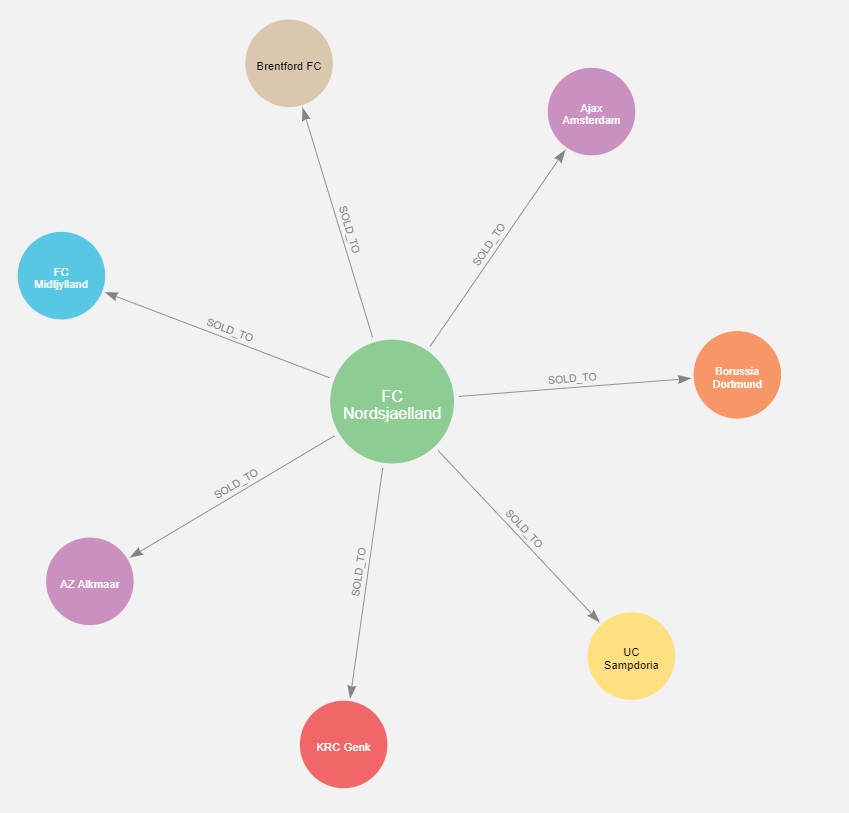

In [33]:
Image(filename='img/nordsjalleand.png', width=650)

The Danish club FC Nordsjaelland has a similar network spread to that of Heracles, but carries a much higher mean buyer rank than the former, due to its relationships with Borussia Dortmund and Ajax.

### 4.2.3. FC Groningen	

In [34]:
edges_agg_filt[edges_agg_filt.index == 'FC Groningen'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
FC Groningen,6,22.76,6,4,0.53,3.79,1,2,0.6943


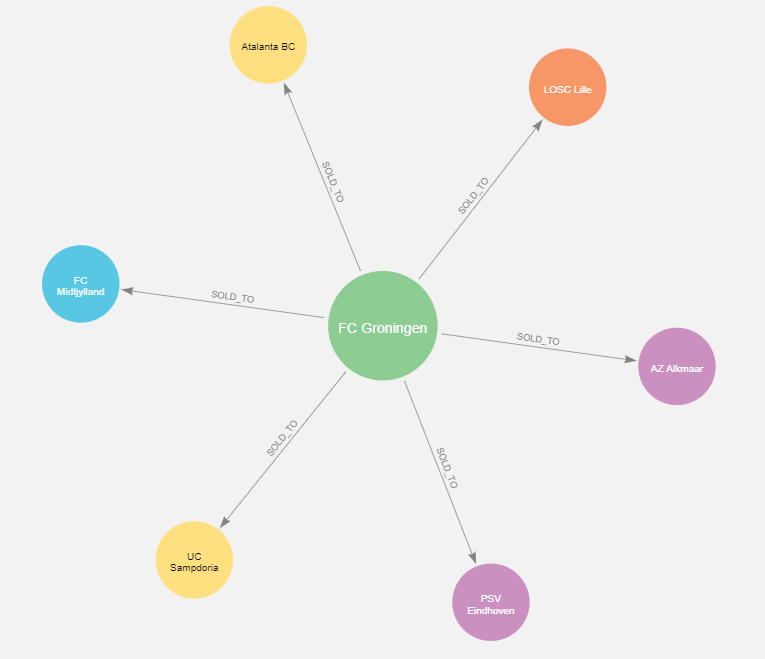

In [35]:
Image(filename='img/groningen.png', width=650)

As the second Dutch club to appear on the list, Groningen share an equal influence amongst teams in the Netherlands (purple nodes), as it does in Italy (yellow nodes). Also, the sale to the French development powerhouse LOSC Lille, that won the Ligue 1 last year despite its emphasis on young talent, most certainly bolsters Groningen's supplier reputation as well.

### 4.2.4. Rio Ave FC

In [36]:
edges_agg_filt[edges_agg_filt.index == 'Rio Ave FC'].drop(columns=['top50'])

,playersSold,income,buyingClub,buyerCountry,buyerRank,incomePerPlayer,clubVarRank,countryVarRank,supplierIndex
sellingClub,,,,,,,,,
Rio Ave FC,10,31.99,6,2,0.78,3.2,2,4,0.6802


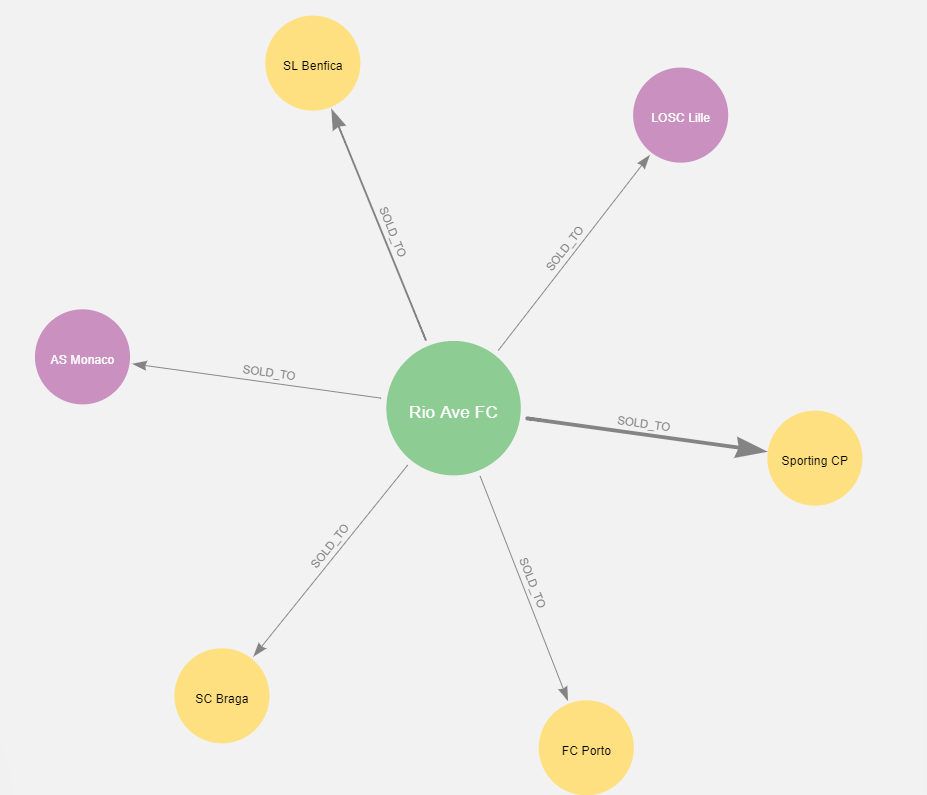

In [37]:
Image(filename='img/rioave.png', width=650)

Rio Ave, which currently finds itself in the Portuguese second division, stands in the network as one of the main suppliers of the Portuguese Top 50 clubs (yellow nodes), but has also sold to the French clubs LOSC Lille, and AS Monaco.

# 5. Conclusion and Future Steps

I hope that this project sheds light on how neo4j graph databases are an apt tool to handle the complexity of the relationships between football/soccer teams. This analysis may have only focused on a single degree between Top 50 Net Spend clubs and the teams that they buy from but in the future I aim to map higher degrees of seperation to generate even more insights into clubs harboring talent that may go under the radar of the largest European clubs.